# Deep models interpretability
This notebooks shows examples of approaches for interpretation of (pre-)trained model predictions.

In [22]:
try:
    import skimage
except ModuleNotFoundError:
    import subprocess as sp
    result = sp.run(
        ['pip3', 'install', 'scikit-image'],
        stdout=sp.PIPE, stderr=sp.PIPE
    )
    
    if result.returncode != 0:
        print(result.stdout.decode('utf-8'))
        print(result.stderr.decode('utf-8'))
    
    import skimage

In [23]:
import urllib
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision.models

import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
!pip install pynvml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
def get_free_gpu():
    from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlDeviceGetCount
    nvmlInit()

    return np.argmax([
        nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(i)).free
        for i in range(nvmlDeviceGetCount())
    ])

if torch.cuda.is_available():
    cuda_id = get_free_gpu()
    device = 'cuda:%d' % (get_free_gpu(), )
    print('Selected %s' % (device, ))
else:
    device = 'cpu'
    print('WARNING: using cpu!')

### please, don't remove the following line
x = torch.tensor([1], dtype=torch.float32).to(device)

Selected cuda:0


In [27]:
# load imagenet class names
import requests
response = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
class_labels = {int(key): value for key, (code, value) in response.json().items()}

In [28]:
class_labels[897]

'washer'

### Task I: manual explanation with smoothgrad (2 points)

Let us begin by implementing our own little explainer for [DenseNet121](https://arxiv.org/abs/1608.06993) pretrained on ImageNet.

For the sake of simplicity, we're gonna rely on [SmoothGrad](https://arxiv.org/pdf/1706.03825.pdf) explainer - a simple average of gradients over noisy inputs.

In [29]:
# model = torchvision.models.densenet121(pretrained=True).train(False).to(device)
model = torchvision.models.resnet50(pretrained=True).train(False).to(device)

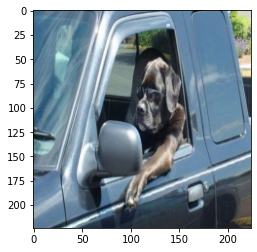

#1: p=0.853	bloodhound (163)
#2: p=0.039	washer (897)
#3: p=0.009	car_mirror (475)
#4: p=0.008	pickup (717)
#5: p=0.008	Weimaraner (178)
#6: p=0.007	Labrador_retriever (208)
#7: p=0.006	Chesapeake_Bay_retriever (209)
#8: p=0.005	limousine (627)
#9: p=0.004	pug (254)
#10: p=0.003	tub (876)


In [30]:
!wget -q https://cdn2.adrianflux.co.uk/wp-fluxposure/uploads/2014/08/no-7.jpg -O img.jpg

image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
plt.imshow(image)
plt.show()

with torch.no_grad():
    image_tensor = torch.as_tensor(image, device=device, dtype=torch.float32)
    image_tensor = image_tensor[None].permute(0, 3, 1, 2)
    probs = torch.softmax(model(image_tensor), dim=-1)[0]
    
for i, class_ix in enumerate(probs.argsort(descending=True)[:10]):
    print(f"#{i + 1}: p={probs[class_ix].item():.3f}\t{class_labels[class_ix.item()]} ({class_ix.item()})")

Now let's implement SmoothGrad itself.

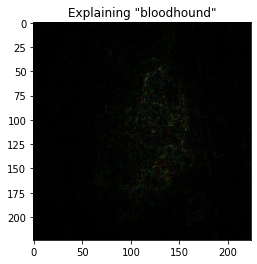

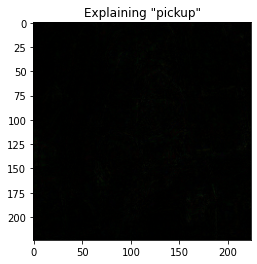

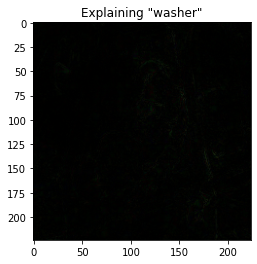

In [31]:
def explain_smoothgrad(image: torch, class_ix, num_runs=32, sigma=0.1):
    image_tensor = torch.as_tensor(image, device=device, dtype=torch.float32)
    image_tensor = image_tensor[None].permute(0, 3, 1, 2)  # shape: [1, 3, h, w]
    list_of_gradiants = []
    for i in range (num_runs):
      copy_ten = image_tensor.clone().detach().requires_grad_(True)
      copy_ten = copy_ten + torch.randn(copy_ten.size()).to(device) * sigma
      outputs=model(copy_ten)
      gradients= [torch.autograd.grad(inputs=copy_ten, outputs=outputs[j][class_ix], allow_unused=True, retain_graph=True) for j in range(len(outputs))]
      #print (gradients[0][0].size())
      list_of_gradiants.append(gradients[0][0])
    average_gradients = torch.cat(list_of_gradiants, 0).mean(0)
    #print (average_gradients.size())
    average_gradients = average_gradients.permute( 1, 2, 0)
    assert tuple(average_gradients.shape) == image.shape
    return abs(average_gradients).cpu().numpy()

for class_ix in 163, 717, 897:  # <-- insert your classes here, use numbers in (brackets)
    plt.title(f'Explaining "{class_labels[class_ix]}"')
    plt.imshow(explain_smoothgrad(image, class_ix), cmap='gray')
    plt.show()

__Let's try it out!__ Peter Higgs nobel prize photo

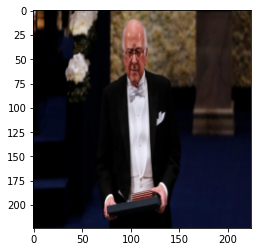

#1: p=0.210	suit (834)
#2: p=0.049	toilet_seat (861)
#3: p=0.039	plunger (731)
#4: p=0.032	vacuum (882)
#5: p=0.026	guillotine (583)
#6: p=0.024	balance_beam (416)
#7: p=0.023	academic_gown (400)
#8: p=0.021	torch (862)
#9: p=0.019	lab_coat (617)
#10: p=0.017	hook (600)


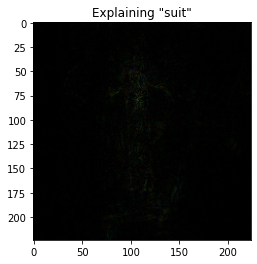

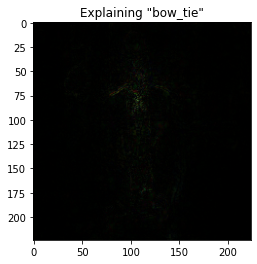

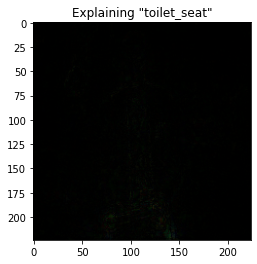

In [32]:
!wget -q https://i.pinimg.com/originals/3a/e1/83/3ae18369ab2e86be83e637ad702ec832.jpg -O img.jpg

image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
plt.imshow(image)
plt.show()

with torch.no_grad():
    image_tensor = torch.as_tensor(image, device=device, dtype=torch.float32)
    image_tensor = image_tensor[None].permute(0, 3, 1, 2)
    probs = torch.softmax(model(image_tensor), dim=-1)[0]
    
for i, class_ix in enumerate(probs.argsort(descending=True)[:10]):
    print(f"#{i + 1}: p={probs[class_ix].item():.3f}\t{class_labels[class_ix.item()]} ({class_ix.item()})")
    
for class_ix in 834, 457, 861:
    plt.title(f'Explaining "{class_labels[class_ix]}"')
    plt.imshow(explain_smoothgrad(image, class_ix), cmap='gray')
    plt.show()

### SHapley Additive exPlanations
Now, let's try something heavier. The current state of the art in explaining model predictions is [SHAP](https://arxiv.org/abs/1705.07874): Shapley Additive Explanations.

This method is based on [Shapley values](https://en.wikipedia.org/wiki/Shapley_value) - a game-theoretic concept that evaluates the contribution of individual players in a cooperative game. Except this time our "players" are input features and the "game" is predicting whichever output the model gave.

Computing Shapley values naively requires $O(F!)$ time where F is the number of features. To make this computation more feasible, authors [proposed](https://arxiv.org/abs/1705.07874) several approximations, one of which relies on averaged gradients. This approximation also requires "background" data - other images similar to the ones in question that can be used as reference points.

In [33]:
try:
    import shap
except ModuleNotFoundError:
    import subprocess as sp
    result = sp.run(
        ['pip3', 'install', 'shap'],
        stdout=sp.PIPE, stderr=sp.PIPE
    )
    
    if result.returncode != 0:
        print(result.stdout.decode('utf-8'))
        print(result.stderr.decode('utf-8'))
    
    import shap

In [34]:
shap.initjs()

# load "background" images - some 50 random images from ImageNet
background, _ = shap.datasets.imagenet50()
background = torch.as_tensor(background / 255.0, device=device, dtype=torch.float32)
background = background.permute(0, 3, 1, 2)

In [35]:
background.size()

torch.Size([50, 3, 224, 224])

In [36]:
# image to explain
!wget -q https://i.pinimg.com/originals/32/da/5c/32da5c3314fcc5ebf1a7b7d1548fcb03.jpg -O img.jpg
image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
image_tensor = torch.as_tensor(image[None], device=device, dtype=torch.float32).permute(0, 3, 1, 2)

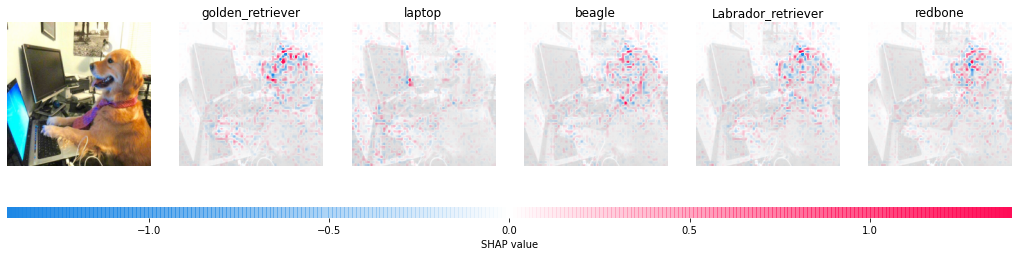

In [37]:
# explain and visualize. If you're not using a powerful V100 GPU, this may take up to 20 minutes.
explainer = shap.GradientExplainer((model, model.layer1), background)
shap_values, indices = explainer.shap_values(image_tensor, ranked_outputs=5, nsamples=200)
shap_values = [np.transpose(values, (0, 2, 3, 1)) for values in shap_values]
index_names = np.vectorize(lambda i: class_labels[i])(indices.cpu().numpy())
shap.image_plot(shap_values, image_tensor.permute(0, 2, 3, 1).cpu().numpy(), index_names)

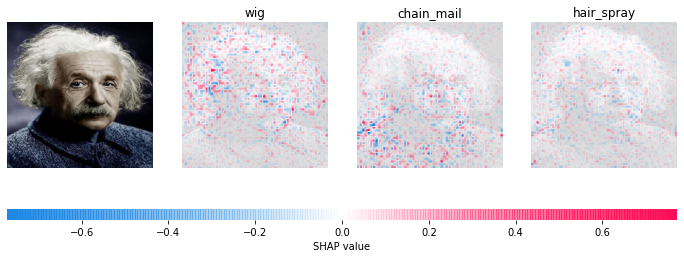

In [38]:
# obligatory physicist reference
!wget -q https://images-na.ssl-images-amazon.com/images/I/51ArQaCkkZL._AC_.jpg -O img.jpg
image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
image_tensor = torch.as_tensor(image[None], device=device, dtype=torch.float32).permute(0, 3, 1, 2)
explainer = shap.GradientExplainer((model, model.layer1), background)
shap_values, indices = explainer.shap_values(image_tensor, ranked_outputs=3, nsamples=200)
shap_values = [np.transpose(values, (0, 2, 3, 1)) for values in shap_values]
index_names = np.vectorize(lambda i: class_labels[i])(indices.cpu().numpy())
shap.image_plot(shap_values, image_tensor.permute(0, 2, 3, 1).cpu().numpy(), index_names)

###### Explaining classical machine learning models

Finally, let's see how SHAP explainers can be applied to more conventional machine learning models like gradient boosting. 

Spoiler: exactly the same from a user's perspective. However, this time we're gonna use a different Shapley approximation implemented in TreeExplainer. For a full set of available explainers, take a look at their official [examples page](https://github.com/slundberg/shap/tree/master/notebooks).

**NB: the following cells requires JavaScript support and should work in Jupyter (not JupyterLab or cocalc)**. 
In that case try running it on Google colab: https://colab.research.google.com/github/yandexdataschool/mlhep2020-assignments/blob/master/notebooks/interpretability/interpretability_demo.ipynb

In [39]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import catboost # pip install catboost

shap.initjs()
X, y = shap.datasets.boston()
ensemble = catboost.CatBoostRegressor(iterations=100, learning_rate=0.1)
ensemble.fit(X, y, verbose=False, plot=False)
explainer = shap.TreeExplainer(ensemble)
shap_values = explainer.shap_values(X)

# visualize explanation of the first example
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

In [41]:
# Explain training data: each *column* is a rotated plot from above, stacked for all training samples
# (this plot is interactive, hover mouse to see feature names)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X)

we can see for low pricing homes on the right side of the graph, high values for crim feature (crime rate) and nox (nitrogen oxides concentration (parts per 10 million)) and lstat(lower status of the population (percent)) contributes havealy in shifting the price prediction below.

on the other side low LSTAT and CRIM and high rm
(average number of rooms per dwelling) contributes to shift the house price prediction higher as we see to the left side of the graph.

in general we can see that lstat plays a very important role , becuase it's almost contributes in every data point (whether in decressing or increasing).

### Task II: Explain Intermediate Layers of Resnet50 on ImageNet (5 points)

Sometimes, computing explanations w.r.t. pixels is more difficult (and less interpretable) than using intermediate layers that are closer to the "output" layer. The trick is to compute low-resolution explanations of output w.r.t. intermediate layer and then resizing them to fit the original image.

Each layer in deep CNN learns filters of increasing complexity. The first layers learn basic feature detection filters such as edges and corners. The middle layers learn filters that detect parts of objects — for faces, they might learn to respond to features like eyes and brows, and deeper layers capture entire objects.

**Your task** is to explain ResNet50 model outputs with respect to the convolution module from 2nd  and 4th layer of the pretrained Resnet50 network using the same GradientExplainer. *The task may require some googling or browsing the [docs](https://shap.readthedocs.io/en/latest) :)*

**Please use at least 10 images from across the internet (or from ImageNet) and compare the 2nd and 4th layer explanations on these images.**


In [65]:
model = torchvision.models.resnet50(pretrained=True).train(False).to(device)

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


In [66]:
# load imagenet class names
import requests
response = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
class_labels = {int(key): value for key, (code, value) in response.json().items()}
print (class_labels)

{0: 'tench', 1: 'goldfish', 2: 'great_white_shark', 3: 'tiger_shark', 4: 'hammerhead', 5: 'electric_ray', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich', 10: 'brambling', 11: 'goldfinch', 12: 'house_finch', 13: 'junco', 14: 'indigo_bunting', 15: 'robin', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water_ouzel', 21: 'kite', 22: 'bald_eagle', 23: 'vulture', 24: 'great_grey_owl', 25: 'European_fire_salamander', 26: 'common_newt', 27: 'eft', 28: 'spotted_salamander', 29: 'axolotl', 30: 'bullfrog', 31: 'tree_frog', 32: 'tailed_frog', 33: 'loggerhead', 34: 'leatherback_turtle', 35: 'mud_turtle', 36: 'terrapin', 37: 'box_turtle', 38: 'banded_gecko', 39: 'common_iguana', 40: 'American_chameleon', 41: 'whiptail', 42: 'agama', 43: 'frilled_lizard', 44: 'alligator_lizard', 45: 'Gila_monster', 46: 'green_lizard', 47: 'African_chameleon', 48: 'Komodo_dragon', 49: 'African_crocodile', 50: 'American_alligator', 51: 'triceratops', 52: 'thunder_snake', 53: 'ringneck_snake', 54: 'hogn

In [67]:
#background images for the model
background, _ = shap.datasets.imagenet50()
background = torch.as_tensor(background / 255.0, device=device, dtype=torch.float32)
background = background.permute(0, 3, 1, 2)

In [68]:
background.size()

torch.Size([50, 3, 224, 224])

In [69]:
# #images to expalin 
# X,y = shap.datasets.imagenet50()
# to_explain = X[[39,41]]

In [70]:
#image to explain 
!wget -q https://i.pinimg.com/originals/3a/e1/83/3ae18369ab2e86be83e637ad702ec832.jpg -O img1.jpg
!wget -q https://gardenerspath.com/wp-content/uploads/2021/01/Spider-Plant-with-a-Cat.jpg -O img0.jpg

image0 = resize(plt.imread('img0.jpg')[..., :3] / 255.0, (224, 224))
image1 = resize(plt.imread('img1.jpg')[..., :3] / 255.0, (224, 224))
image2 = resize(plt.imread('img2.jpg')[..., :3] / 255.0, (224, 224))
image3 = resize(plt.imread('img3.jpg')[..., :3] / 255.0, (224, 224))
image4 = resize(plt.imread('img4.jpg')[..., :3] / 255.0, (224, 224))
image5 = resize(plt.imread('img5.jpg')[..., :3] / 255.0, (224, 224))
image6 = resize(plt.imread('img6.jpg')[..., :3] / 255.0, (224, 224))
image7 = resize(plt.imread('img7.jpg')[..., :3] / 255.0, (224, 224))
image8 = resize(plt.imread('img8.jpg')[..., :3] / 255.0, (224, 224))
image9 = resize(plt.imread('img9.jpg')[..., :3] / 255.0, (224, 224))

#image_tensor = torch.as_tensor(image[None], device=device, dtype=torch.float32).permute(0, 3, 1, 2)
#image_tensor1 = torch.as_tensor(image1[None], device=device, dtype=torch.float32).permute(0, 3, 1, 2)

to_explain = torch.as_tensor([image1,image0, image2, image3, image4, image5, image6, image7, image8, image9], device=device, dtype=torch.float32).permute(0, 3, 1, 2)
print (to_explain.size())
#to_explain = np.array([image_tensor.cpu(), image_tensor1.cpu()])

torch.Size([10, 3, 224, 224])


In [71]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

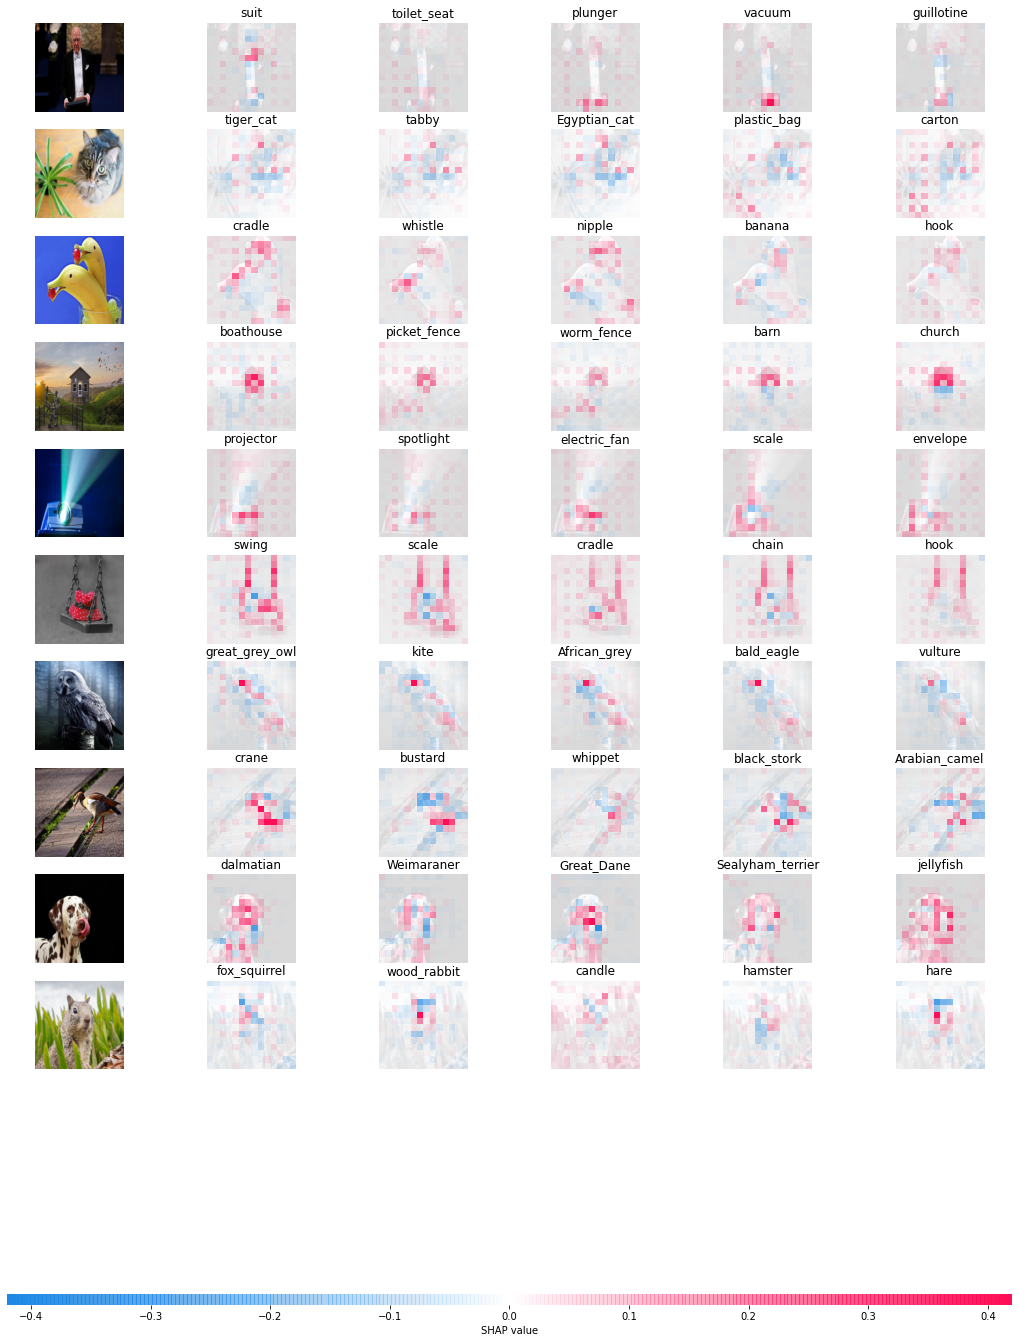

In [72]:
# this code explains how the input for the fourth layer affects the output of the model
e = shap.GradientExplainer((model, model.layer4), background)
shap_values,indexes = e.shap_values(to_explain, ranked_outputs=5, nsamples=200)

# get the names for the classes
index_names = np.vectorize(lambda i: class_labels[i])(indexes.cpu().numpy())

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap.image_plot(shap_values, to_explain.permute(0, 2, 3, 1).cpu().numpy(), index_names)


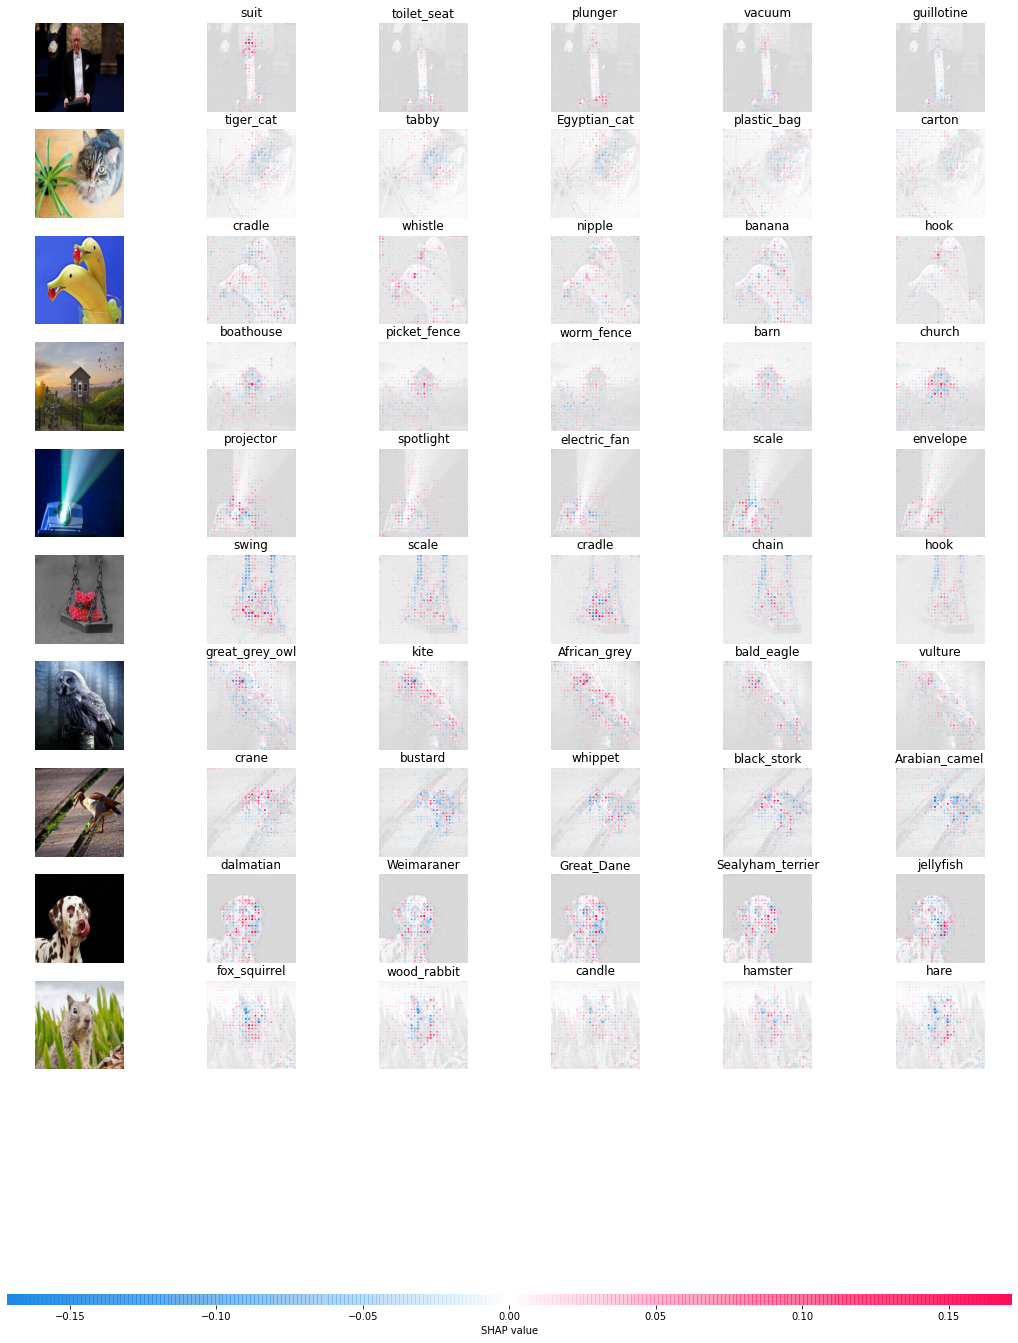

In [73]:
# this code explains how the input for the second layer affects the output of the model
e = shap.GradientExplainer((model, model.layer2), background)
shap_values,indexes = e.shap_values(to_explain, ranked_outputs=5, nsamples=200)

# get the names for the classes
index_names = np.vectorize(lambda i: class_labels[i])(indexes.cpu().numpy())

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap.image_plot(shap_values, to_explain.permute(0, 2, 3, 1).cpu().numpy(), index_names)

e = shap.GradientExplainer((model, layer argument), background)
tha above command , according to the https://shap-lrjball.readthedocs.io/en/latest/generated/shap.GradientExplainer.html is reponsible of calculating shap values for the input of the layer argument.

thus after Gradient Explainer for 10 random images in both layer 2 and 4 in ResNet50 we can see that layer2 focus on smaller pixcls and simple general features (for example the chains of the swing in imag6 does not contribute to the final output as a swing on the contirary they are marked with blue which means lesser probability) whereas the layer 4 focuses on large areas of the images (for examples the chains in the swing image6 now contributes more to the probabilites of the output as a swing and now are marked with red).


another example is  Peter Higgs nobel prize photo : in layer 2 we see that the tie and the face gives more contribution to the probability of beign a suit , but we can see that in layer 4 the tie contributes even more for the suit prediction , but the prize (degree or the book that he is holding) pixels contributes in the opposite direction of the suit prediction.

another example is the banana example(image 3) we can see that although the banana wasn't the main prediction for the model but in layer2 banana we can see that the shape and the colors of the red colored pixcels increase the banana output , but since this layer does not consider a larger areas , and by moving to the layer4 we can see that the dots on the banana (imitating eyes) and the cherry inside the banana (imitating mouths) decrese the probability of a banana in the output in comparision to the nipple predictions (which can be seen that the pixels of the cherries had a huge influence on that prediction as an output).

and using the same way we can  interpulate ResNet50 model outputs with respect to the convolution module from 2nd and 4th layer using GradientExplainer for multiple other images (images used in this notebook where drawn randomly form internet).




## References

* SHAP explainer based on superpixels - [notebook](https://slundberg.github.io/shap/notebooks/ImageNet%20VGG16%20Model%20with%20Keras.html)
* SHAP reference notebook - [view on github](https://github.com/slundberg/shap/tree/master/notebooks)
* More various explainers in [ELI5](https://github.com/TeamHG-Memex/eli5)
* Same notebook on Google [Colab](https://colab.research.google.com/github/yandexdataschool/mlhep2020-assignments/blob/master/notebooks/interpretability/interpretability_demo.ipynb)